# Solve the NS equations

## Governing Equation

Momentum equation:

$$
\begin{aligned}
u_t + (uu_x+vu_y) &= -p_x+\nu(u_{xx}+u_{yy})\\
v_t + (uv_x+vv_y) &= -p_y+\nu(v_{xx}+v_{yy})
\end{aligned}
$$

By using stream function:

$$
\begin{aligned}
    u&=\psi_y\\
    v&=-\psi_x
\end{aligned}
$$

The continuity equation $u_x+v_y=0$ can be automatically satisfied.

![](tube.png)

## Import some Libraries and Dependencies

In [34]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from collections import OrderedDict
from pyDOE import lhs
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib import cm

In [35]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

nu = 0.01

In [36]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # parameters
        self.depth = len(layers) - 1

        # set up layer order dict
        self.activation = torch.nn.Tanh

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1),
             torch.nn.Linear(layers[-2], layers[-1]))
        )
        layer_dict = OrderedDict(layer_list)

        # deploy layers
        self.layers = torch.nn.Sequential(layer_dict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [37]:
class PINNs():
    def __init__(self, input_bcs, output_bcs, input_F, lb, ub, layers):
        self.lb = lb
        self.ub = ub
        for i, input_bc in enumerate(input_bcs):
            input_bcs[i] = torch.tensor(
                input_bc, requires_grad=True).float().to(device)
        for output_bc in output_bcs:
            for key, value in output_bc.items():
                output_bc[key] = torch.tensor(
                    value, requires_grad=True).float().to(device)
        self.input_bcs = input_bcs
        self.output_bcs = output_bcs
        self.input_F = torch.tensor(
            input_F, requires_grad=True).float().to(device)
        self.layers = layers

        # deep neural networks
        self.dnn = DNN(layers).to(device)

        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0

    def getXYT(self, input):
        X = input[:, 0:1]
        Y = input[:, 1:2]
        T = input[:, 2:3]
        return X, Y, T
    
    def grad(self, y, x):
        y_x = torch.autograd.grad( 
            y, x, grad_outputs=torch.ones_like(y),
            retain_graph=True, create_graph=True
        )[0]
        return y_x
    
    def netPsiP(self, x, y, t):
        psi_p = self.dnn(torch.cat([x, y, t], dim=1))
        psi = psi_p[:, 0:1]
        p = psi_p[:, 1:2]
        return psi, p
    
    def netU(self, x, y, psi):
        u = self.grad(psi, y)
        v = -self.grad(psi, x)
        return u, v
    
    def netF(self, x, y, t):
        psi, p = self.netPsiP(x, y, t)
        u, v = self.netU(x, y, psi)
        ut = self.grad(u, t)
        vt = self.grad(v, t)
        ux = self.grad(u, x)
        vx = self.grad(v, x)
        uy = self.grad(u, y)
        vy = self.grad(v, y)
        px = self.grad(p, x)
        py = self.grad(p, y)
        uxx = self.grad(ux, x)
        vxx = self.grad(vx, x)
        uyy = self.grad(uy, y)
        vyy = self.grad(vy, y)
        fu = ut + (u*ux+v*uy) + px - nu*(uxx + uyy)
        fv = vt + (u*vx+v*vy) + py - nu*(vxx + vyy)
        return fu, fv

    def loss_func(self):
        self.optimizer.zero_grad()
        x, y, t = self.getXYT(self.input_F)
        fu_pred, fv_pred = self.netF(x, y, t)
        loss_fu = torch.mean((fu_pred)**2)
        loss_fv = torch.mean((fv_pred)**2)
        loss_bcs = torch.zeros(len(self.input_bcs), 3)
        for i in range(len(self.input_bcs)):
            input_bc = self.input_bcs[i]
            output_bc = self.output_bcs[i]
            x, y, t = self.getXYT(input_bc)
            psi, p = self.netPsiP(x, y, t)
            u, v = self.netU(x, y, psi)
            j = 0
            for key, value in output_bc.items():
                if key == "U":
                    bc_pred = u
                elif key == "V":
                    bc_pred = v
                elif key == "Ux":
                    bc_pred = self.grad(u, x)
                elif key == "Uy":
                    bc_pred = self.grad(u, y)
                elif key == "Vx":
                    bc_pred = self.grad(v, x)
                elif key == "Vy":
                    bc_pred = self.grad(v, y)
                elif key == "P":
                    bc_pred = p
                elif key == "Px":
                    bc_pred = self.grad(p, x)
                elif key == "Py":
                    bc_pred = self.grad(p, y)
                loss_bcs[i, j]  = torch.mean((bc_pred - value)**2)
                j += 1
        loss = loss_fu + loss_fv + torch.sum(loss_bcs)
        
        loss.backward()
        self.iter += 1
        if self.iter %100 == 0:
            print("-"*15*5)
            info1 = "{:<15}{:<15}".format("Iter:", self.iter)
            info2 = "{:<15}{:<15}{:<15}{:<15}".format(
                "loss", "loss_fu", "loss_fv", "loss_bc")
            info3 = "{:<15.5e}{:<15.5e}{:<15.5e}{:<15.5e}".format(
                loss.item(), loss_fu.item(), loss_fu.item(),
                torch.sum(loss_bcs).item())
            print(info1)
            print(info2)
            print(info3)
            info4 = "{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}".format( 
                "", "init", "bc1", "bc2", "bc3", "bc4"
            )
            print(info4)
            for i in range(3):
                info5 = \
                    "{:<15}{:<15.5e}{:<15.5e}{:<15.5e}{:<15.5e}{:<15.5e}".\
                        format("Type{}".format(i+1),
                        loss_bcs[0, i].item(), 
                        loss_bcs[1, i].item(), 
                        loss_bcs[2, i].item(), 
                        loss_bcs[3, i].item(), 
                        loss_bcs[4, i].item(), 
                        )
                print(info5)
        return loss

    def train(self):
        self.dnn.train()

        # Backward and optimize
        self.optimizer.step(self.loss_func)

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 2:3], requires_grad=True).float().to(device)

        self.dnn.eval()
        psi, p = self.netPsiP(x, y, t)
        u, v = self.netU(x, y, psi)
        return u, v, p



In [38]:
U_in = np.array([1., 0.])
p_out = 0.

N_b = 1000
N_F = 10000

# input: (x, y, t)
# output: (psi, p)
layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]

N_x = 100
N_y = 100
N_t = 100

x_lim = np.array([0.0, 2.0])
y_lim = np.array([0.0, 0.5])
t_lim = np.array([0.0, 2.0])

lb = np.array([x_lim[0], y_lim[0], t_lim[0]])
ub = np.array([x_lim[1], y_lim[1], t_lim[1]])

x = np.linspace(x_lim[0], x_lim[1], N_x)
y = np.linspace(y_lim[0], y_lim[1], N_y)
t = np.linspace(t_lim[0], t_lim[1], N_t)

mesh2list = lambda X, Y, T: np.hstack(
    [ 
        X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]
    ]
)

# I.C., t = 0
X, Y, T = np.meshgrid(x, y, t[0:1])
input_init = mesh2list(X, Y, T)
U = np.zeros_like(input_init[:, 0:1])
V = np.zeros_like(input_init[:, 0:1])
P = np.zeros_like(input_init[:, 0:1])
output_init = {
    "U": U,
    "V": V,
    "P": P
}

# Left B.C., x = 0
X, Y, T = np.meshgrid(x[0:1], y, t)
input_bc1 = mesh2list(X, Y, T)
U = np.ones_like(input_bc1[:, 0:1])
V = np.zeros_like(input_bc1[:, 0:1])
Px = np.zeros_like(input_bc1[:, 0:1])
output_bc1 = {
    "U": U,
    "V": V,
    "Px": Px
}

# Top B.C., y = Ly
X, Y, T = np.meshgrid(x, y[-1::], t)
input_bc2 = mesh2list(X, Y, T)
U = np.zeros_like(input_bc2[:, 0:1])
V = np.zeros_like(input_bc2[:, 0:1])
Py = np.zeros_like(input_bc2[:, 0:1])
output_bc2 = {
    "U": U,
    "V": V,
    "Py": Py
}

# Bottom B.C., y = 0
X, Y, T = np.meshgrid(x, y[0:1], t)
input_bc3 = mesh2list(X, Y, T)
U = np.zeros_like(input_bc3[:, 0:1])
V = np.zeros_like(input_bc3[:, 0:1])
Py = np.zeros_like(input_bc3[:, 0:1])
output_bc3 = {
    "U": U,
    "V": V,
    "Py": Py
}

# Right B.C., x = Lx
X, Y, T = np.meshgrid(x[-1::], y, t)
input_bc4 = mesh2list(X, Y, T)
Ux = np.zeros_like(input_bc4[:, 0:1])
Vx = np.zeros_like(input_bc4[:, 0:1])
P = np.zeros_like(input_bc4[:, 0:1])
output_bc4 = {
    "Ux": Ux,
    "Vx": Vx,
    "P": P
}

def data_sample(input, output, N_b):
    # Make a sampling among the input array and output dictionary
    idx = np.random.choice(input.shape[0], N_b, replace=False)
    input = input[idx, :]
    for key, value in output.items():
        idx = np.random.choice(value.shape[0], N_b, replace=False)
        output[key] = value[idx, :]
    return input, output

input_init, output_init = data_sample(input_init, output_init, N_b)
input_bc1,  output_bc1 = data_sample(input_bc1, output_bc1, N_b)
input_bc2,  output_bc2 = data_sample(input_bc2, output_bc2, N_b)
input_bc3,  output_bc3 = data_sample(input_bc3, output_bc3, N_b)
input_bc4,  output_bc4 = data_sample(input_bc4, output_bc4, N_b)

input_bcs = [input_init, input_bc1, input_bc2, input_bc3, input_bc4]
output_bcs = [output_init, output_bc1, output_bc2, output_bc3, output_bc4]

input_F = lb + (ub-lb)*lhs(3, N_F)
input_F = np.vstack([input_F, input_init, input_bc1, input_bc2, input_bc3, input_bc4])

In [39]:
model = PINNs(input_bcs, output_bcs, input_F, lb, ub, layers)

In [40]:
%%time

model.train()

---------------------------------------------------------------------------
Iter:          100            
loss           loss_fu        loss_fv        loss_bc        
2.62384e-01    2.52990e-02    2.52990e-02    2.32416e-01    
               init           bc1            bc2            bc3            bc4            
Type1          3.15263e-02    1.20305e-01    2.86305e-02    1.48324e-02    1.26758e-03    
Type2          4.99066e-03    4.42143e-03    1.49407e-02    8.10961e-03    1.71246e-04    
Type3          1.24456e-04    2.38720e-03    1.35927e-04    5.55938e-04    1.73277e-05    
---------------------------------------------------------------------------
Iter:          200            
loss           loss_fu        loss_fv        loss_bc        
2.06308e-01    2.55501e-02    2.55501e-02    1.75305e-01    
               init           bc1            bc2            bc3            bc4            
Type1          3.39177e-02    7.42392e-02    1.64645e-02    6.67898e-03    2.19309e-03 

In [41]:
torch.save(model.dnn, "ns.pt")

In [59]:
N_x = 1000
N_y = 1000
N_t = 1

x_lim = np.array([0.0, 2.0])
y_lim = np.array([0.0, 0.5])
t_lim = np.array([0.0, 2.0])

lb = np.array([x_lim[0], y_lim[0], t_lim[0]])
ub = np.array([x_lim[1], y_lim[1], t_lim[1]])

time = 2.0

x = np.linspace(x_lim[0], x_lim[1], N_x)
y = np.linspace(y_lim[0], y_lim[1], N_y)
# t = np.linspace(t_lim[0], t_lim[1], N_t)
t = np.linspace(time, time, N_t)

X, Y, T = np.meshgrid(x, y, t)
X_pred = np.hstack( 
    (X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None])
)
u_pred, v_pred, p_pred = model.predict(X_pred)
u_pred = u_pred.detach().cpu().numpy()
v_pred = v_pred.detach().cpu().numpy()
p_pred = p_pred.detach().cpu().numpy()
U_pred = u_pred.reshape(N_x, N_y)
V_pred = v_pred.reshape(N_x, N_y)
Umag_pred = np.sqrt(U_pred**2+V_pred**2)
P_pred = p_pred.reshape(N_x, N_y)

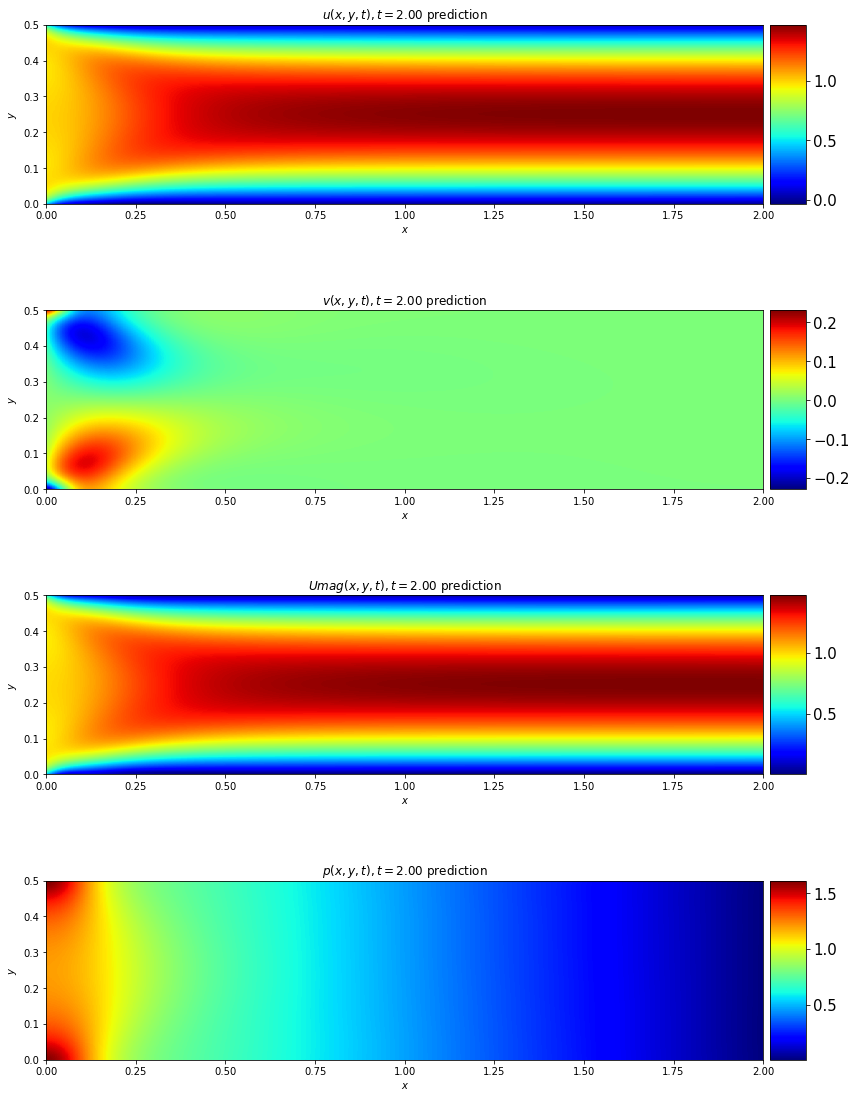

In [71]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(12, 16))
# fig.suptitle("$\\alpha={:.2f}$".format(alpha_value), fontsize = 24)

###### Prediction U#####################
plot_data = [U_pred, V_pred, Umag_pred, P_pred]
plot_name = ["u", "v", "Umag", "p"]

for i in range(4):
    ax = fig.add_subplot(411+i)
    h = ax.imshow(plot_data[i], interpolation='nearest', cmap=cm.jet, 
                extent=[x.min(), x.max(), y.min(), y.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = fig.colorbar(h, cax=cax)
    cbar.ax.tick_params(labelsize=15) 

    if 0:
        ax.plot(
            input_F[:,0], 
            input_F[:,1], 
            'kx', label = 'Data (%d points)' % (input_F.shape[0]), 
            markersize = 4,  # marker size doubled
            clip_on = False,
            alpha=1.0
        )

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    # font size doubled
    ax.set_title('${}(x,y,t),t={:.2f}$ prediction'.format(plot_name[i], time))
    ax.set_aspect(1)
fig.tight_layout()

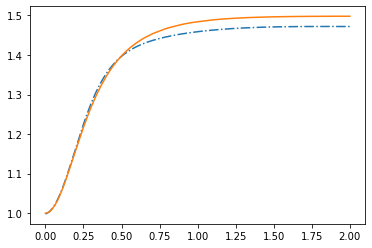

In [67]:
n = int(N_x/2)
plt.plot(X[n, :], U_pred[n, :], '-.')
import pandas as pd
df = pd.read_csv("sample.csv")
u_foam = df["U:0"]
x_foam = df["Points:0"]
plt.plot(x_foam, u_foam)

In [94]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

N_frame = 20
def generateData(p):
    N_x = 1000
    N_y = 1000
    N_t = 1

    x_lim = np.array([0.0, 2.0])
    y_lim = np.array([0.0, 0.5])
    t_lim = np.array([0.0, 2.0])

    time = 2.0*p/N_frame

    x = np.linspace(x_lim[0], x_lim[1], N_x)
    y = np.linspace(y_lim[0], y_lim[1], N_y)
    # t = np.linspace(t_lim[0], t_lim[1], N_t)
    t = np.linspace(time, time, N_t)

    X, Y, T = np.meshgrid(x, y, t)
    X_pred = np.hstack( 
        (X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None])
    )
    u_pred, v_pred, p_pred = model.predict(X_pred)
    u_pred = u_pred.detach().cpu().numpy()
    v_pred = v_pred.detach().cpu().numpy()
    p_pred = p_pred.detach().cpu().numpy()
    U_pred = u_pred.reshape(N_x, N_y)
    V_pred = v_pred.reshape(N_x, N_y)
    Umag_pred = np.sqrt(U_pred**2+V_pred**2)
    P_pred = p_pred.reshape(N_x, N_y)
    plot_data = [U_pred, V_pred, Umag_pred, P_pred]
    plot_name = ["u", "v", "Umag", "p"]
    return x, y, plot_data, plot_name

In [95]:
def animate(fig, p):
    """ The aesthetic setting has changed. """

    ####### Row 0: u(t,x) ##################    

    # fig.suptitle("$\\alpha={:.2f}$".format(alpha_value), fontsize = 24)

    ###### Prediction U#####################
    x, y, plot_data, plot_name = generateData(p)
    vmins = [0, -0.3, 0, 1.6]
    vmaxs = [1.5, 0.3, 1.5, 1.6]
    time = p*2.0/N_frame

    for i in range(4):
        ax = fig.add_subplot(411+i)
        h = ax.imshow(plot_data[i], interpolation='nearest', cmap=cm.jet, 
                    vmin = vmins[i], vmax = vmaxs[i],
                    extent=[x.min(), x.max(), y.min(), y.max()], 
                    origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=15) 

        if 0:
            ax.plot(
                input_F[:,0], 
                input_F[:,1], 
                'kx', label = 'Data (%d points)' % (input_F.shape[0]), 
                markersize = 4,  # marker size doubled
                clip_on = False,
                alpha=1.0
            )

        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        # font size doubled
        ax.set_title('${}(x,y,t),t={:.2f}$ prediction'.format(plot_name[i], time))
        ax.set_aspect(1)
    fig.tight_layout()
    return fig

In [ ]:
from matplotlib import animation
from tqdm.notebook import tqdm

for i in tqdm(range(21)):
    fig = plt.figure(figsize=(12, 16))
    fig = animate(fig, i)
    fig.savefig("results/{:05d}.png".format(i), facecolor='white', transparent=False)